In [ ]:
# Cargar los datos y obtener el modelo
from common import *
del perform_sensitivity_analysis ### AUX TEMP: ELIMINO EL IMPORT DE ESTA FN XQ ESTOY PROBANDO
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 5700
* Total benefit=5700
Production of A: 50.0
Production of B: 80.0
Production of C: 0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results
rhs_values = []
dual_values = []

#real_rhs_value = 0

m = 0.01


In [ ]:
# Report values for the chart

def report(rhs_value, dual_value):
    rhs_values.append(rhs_value)
    dual_values.append(dual_value) #Diferencia con grafico Costo Op dem min B vs disp
    


In [ ]:
#### PROBANDOOOOOOOOOOOO
constraint_nameX = 'Disp_Equipo2'  # The name of the constraint X to analyze
constraint_nameY = mdl.get_constraint_by_name(constraint_nameX)

# Perform sensitivity analysis of the RHS
### Aux: VM, Funcional, costo op
# Constraint es el nombre de la restricción cuyos lower y upper bounds queremos obtener,
def perform_sensitivity_analysis(mdl, constraint):
    lp = LinearRelaxer.make_relaxed_model(mdl)
    lp.solve()
    cpx = lp.get_engine().get_cplex()

    rhs=cpx.solution.sensitivity.rhs()
    names = cpx.linear_constraints.get_names()
    print("[DEBUG] NOMBRES DE LAS RESTRICCIONES:\n", names)
    idx=names.index(constraint)
    print(f"Lower y upper para restr: {constraint}: {rhs[idx]}")
    
    #return cpx.solution.sensitivity.rhs()
    return rhs[idx]

In [ ]:
### PROBANDOOO
constraint_nameX = 'Disp_Equipo2'  # The name of the constraint X to analyze
constraint_nameY = mdl.get_constraint_by_name(constraint_nameX)

perform_sensitivity_analysis(mdl, constraint_nameX)

[DEBUG] NOMBRES DE LAS RESTRICCIONES:
 ['Disp_Equipo1', 'Disp_Equipo2', 'Disp_Equipo3', 'DemandMax_A', 'DemandMax_B', 'DemandMax_C', 'DemandMin_A', 'DemandMin_B', 'DemandMin_C']
Lower y upper para restr: Disp_Equipo2: (126.0, 1e+20)


(126.0, 1e+20)

In [ ]:
def iterate_over_rhs(constraint_nameX, constraint_nameY): # aux: var mdl, 'm', y funciones.
    c = mdl.get_constraint_by_name(constraint_nameX)
    if c is None:
        print("Constraint with name '{0}' not found.".format(constraint_nameX))
        return
            
    # Perform initial sensitivity analysis to get the starting lower and upper bounds
    initial_sensitivity = perform_sensitivity_analysis(mdl, constraint_nameX) # Aux: obtiene (lower, upper)
    print("[debug] initial sensitivity", initial_sensitivity)
    print("[debug] constraint_nameY:", constraint_nameY)
    print("[debug] constraint_nameY type:", type(constraint_nameY))
    
    # # Find the sensitivity range for the specified constraint
    # for c_sens, (lower, upper) in zip(mdl.iter_constraints(), initial_sensitivity):
    #     print("[debug] for c_sens, (lower, upper):", c_sens, (lower, upper))
    #     if c_sens.name == constraint_nameX:

    (lower, upper) = initial_sensitivity
    print("[debug] (lower, upper):", (lower, upper))

    # Report the real RHS value for the chart
    #global real_rhs_value #use the global keyword to declare that you want the function to update the global variable
    real_rhs_value = c.rhs.constant ### aux: ok agrega el actual, es una cte aparte
    report(real_rhs_value, constraint_nameY.dual_value)


    # *********Store and report the initial lower and upper bounds for the chart*********
    print("---Initial lower bound: {0}".format(lower))
    rhs = lower
    solution = solve(c, rhs, mdl, products, produccion_vars)
    if solution is not None:
        report(rhs, constraint_nameY.dual_value)

    print("---Initial upper bound: {0}".format(upper))
    rhs = upper
    solution = solve(c, rhs, mdl, products, produccion_vars)
    if solution is not None and rhs < mdl.infinity:
        report(rhs, constraint_nameY.dual_value)
    # ********* End of lower and upper bounds *********
    
    
    #Decrease rhs starting from lower bound - m
    rhs = lower - m
    while True:
        print("[debug] Viendo para rhs:", rhs)
        if rhs < 0:
            break ## Stop if the rhs is lower than 0                
    
        solution = solve(c, rhs, mdl, products, produccion_vars)
        if solution is None:
            break  # Stop if the model is infeasible
        else:
            #report(rhs, constraint_nameY.dual_value) #Diferencia con grafico funcional vs disp
            #report(c_sens.rhs.constant, constraint_nameY.dual_value) ### Aux, veamos si así queda 126 y no 125.99
            print("[debug al append] rhs:", rhs)
            print("[debug al append] c_sens.rhs.constant:", c.rhs.constant)
            report(rhs + m, constraint_nameY.dual_value)
            
        # Perform sensitivity analysis to get the new lower bound
        new_sensitivity = perform_sensitivity_analysis(mdl, constraint_nameX)
        print("[debug] sensitivity", new_sensitivity)            
        # for c_new_sens, (new_lower, _) in zip(mdl.iter_constraints(), new_sensitivity):
        #     if c_new_sens.name == constraint_nameX: 

        (new_lower, _) = new_sensitivity
        rhs = new_lower
        if rhs < 0:
            break ## Stop if the rhs is lower than 0                
            
        solution = solve(c, rhs, mdl, products, produccion_vars)
        if solution is None:
            break  # Stop if the model is infeasible
        #report(c.rhs.constant, constraint_nameY.dual_value)
        report(rhs, constraint_nameY.dual_value)
        
        rhs = new_lower - m #### aux: es para la sgte vuelta del while


    # Increase rhs starting from upper bound + m
    rhs = upper + m
    
    while True:
        print("[debug] Viendo para rhs:", rhs)
        if rhs >= mdl.infinity:
            break ## Stop if the rhs reaches or exceeds infinity

        solution = solve(c, rhs, mdl, products, produccion_vars)
        if solution is None:
            break  # Stop if the model is infeasible
        else:
            report(rhs-m, constraint_nameY.dual_value) #Diferencia con grafico funcional vs disp

        # Perform sensitivity analysis to get the new upper bound
        new_sensitivity = perform_sensitivity_analysis(mdl, constraint_nameX)
        # for c_new_sens, (_, new_upper) in zip(mdl.iter_constraints(), new_sensitivity):
        #     if c_new_sens.name == constraint_nameX:
        (_, new_upper) = new_sensitivity
        rhs = new_upper
        if rhs >= mdl.infinity:
            break ## Stop if the rhs reaches or exceeds infinity

        solution = solve(c, rhs, mdl, products, produccion_vars)
        if solution is None:
            break  # Stop if the model is infeasible
        #report(c.rhs.constant, constraint_nameY.dual_value)
        report(rhs, constraint_nameY.dual_value)
        
        rhs = new_upper + m
        
    return real_rhs_value

In [ ]:
### Debug
print("rhs_values:",rhs_values)
#print("real_rhs_value:",real_rhs_value) # aux: es el actual, el bi
print("dual_values:", dual_values)
print("")
#print("constraint_nameX:", constraint_nameX)
#print("constraint_nameY:", constraint_nameY)
print("")
print("mdl:", mdl)
print("mdl:", mdl.solution)
# if 0 not in rhs_values, significa que antes de su mín es incompatible.., revisar

rhs_values: []
dual_values: []


mdl: docplex.mp.Model['guia5problematipo2']
mdl: solution for: guia5problematipo2
objective: 5700
status: OPTIMAL_SOLUTION(2)
produccion_A_50_100_0=50.000
produccion_B_40_120_80=80.000



In [ ]:
# Usage of the iterate_over_rhs method
constraint_nameX = 'Disp_Equipo3'  # The name of the constraint X to analyze
constraint_nameY = mdl.get_constraint_by_name('Disp_Equipo3') # The name of the constraint Y to analyze

real_rhs_value = iterate_over_rhs(constraint_nameX, constraint_nameY)

[DEBUG] NOMBRES DE LAS RESTRICCIONES:
 ['Disp_Equipo1', 'Disp_Equipo2', 'Disp_Equipo3', 'DemandMax_A', 'DemandMax_B', 'DemandMax_C', 'DemandMin_A', 'DemandMin_B', 'DemandMin_C']
Lower y upper para restr: Disp_Equipo3: (80.0, 140.0)
[debug] initial sensitivity (80.0, 140.0)
[debug] constraint_nameY: Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 110
[debug] constraint_nameY type: <class 'docplex.mp.constr.LinearConstraint'>
[debug] (lower, upper): (80.0, 140.0)
---Initial lower bound: 80.0
---
- Adjusting RHS to: 80.0
* Production model solved with objective: 3200
* Total benefit=3200
Production of A: 0
Production of B: 80.0
Production of C: 0
---Initial upper bound: 140.0
---
- Adjusting RHS to: 140.0
* Production model solved with objective: 8200
* Total benefit=8200
Production of A: 100.0
Production of B: 80.0
Production of C: 0
[debug] Viendo para rhs: 79.99
---
- Adjusting RHS to: 79.99
No solution found for RHS value: 79.9

In [ ]:
### Debug _ Notar que quedó en 12800 el Z, al terminar de iterar
print("rhs_values:",rhs_values)
print("real_rhs_value:",real_rhs_value) # es el actual, el bi
print("dual_values:", dual_values)
print("")
print("constraint_nameX:", constraint_nameX)
print("constraint_nameY:", constraint_nameY)
print("")
print("mdl:", mdl)
print("mdl:", mdl.solution) # por eso esto printea basura (no es la solución óptima de verdad)
# if 0 not in rhs_values, significa que antes de su mín es incompatible.., revisar

rhs_values: [110, 80.0, 140.0, 140.0, 172.0, 172.0, 272.0, 272.0]
real_rhs_value: 110
dual_values: [83.33333333333334, 83.33333333333334, 83.33333333333334, 50.0, 50.0, 30.0, 30.0, 0]

constraint_nameX: Disp_Equipo3
constraint_nameY: Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 272.01

mdl: docplex.mp.Model['guia5problematipo2']
mdl: solution for: guia5problematipo2
objective: 12800
status: OPTIMAL_SOLUTION(2)
produccion_B_40_120_80=80.000
produccion_C_30_999999999999999_0=320.000



# Entonces, las dos mejoras
## Cambiando la restricción para el análisis y el gráfico, y las mejoras son ordenar la lista y sacar el 'infinito' del final

In [ ]:
### EJECUTAR ESTO DE NUEVO PARA QUE MDL NO HAYA QUEDADO VALIENDO NONE DE UNA ITERACIÓN ANTERIOR
#from common import *
#del perform_sensitivity_analysis ### AUX TEMP: ELIMINO EL IMPORT DE ESTA FN XQ ESTOY PROBANDO
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)

### E INICIALIZAR LISTAS DE NUEVO PARA QUE NO ACUMULEN SOBRE LO DE LA CORRIDA ANTERIOR
# Initialize lists to store the results
rhs_values = []
dual_values = []

#real_rhs_value = 0

m = 0.01

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 5700
* Total benefit=5700
Production of A: 50.0
Production of B: 80.0
Production of C: 0


In [ ]:
### AHORA CON DISP EQUIPO *2*.
# Usage of the iterate_over_rhs method
constraint_nameX = 'Disp_Equipo3'  # The name of the constraint X to analyze
constraint_nameY = mdl.get_constraint_by_name(constraint_nameX)  # The name of the constraint X to analyze

real_rhs_value = iterate_over_rhs(constraint_nameX, constraint_nameY)

NameError: name 'perform_sensitivity_analysis' is not defined

In [ ]:
### Debug _ viendo
print("rhs_values:",rhs_values)
print("real_rhs_value:",real_rhs_value) # es el actual, el bi
print("dual_values:", dual_values)
print("")
print("constraint_nameX:", constraint_nameX)
print("constraint_nameY:", constraint_nameY)
print("")
print("mdl:", mdl)
print("mdl:", mdl.solution)
# if 0 not in rhs_values, significa que antes de su mín es incompatible.. revisar

rhs_values: [110, 80.0, 140.0, 140.0, 172.0, 172.0, 272.0, 272.0]
real_rhs_value: 110
dual_values: [83.33333333333334, 83.33333333333334, 83.33333333333334, 50.0, 50.0, 30.0, 30.0, 0]

constraint_nameX: Disp_Equipo3
constraint_nameY: Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 272.01

mdl: docplex.mp.Model['guia5problematipo2']
mdl: solution for: guia5problematipo2
objective: 12800
status: OPTIMAL_SOLUTION(2)
produccion_B_40_120_80=80.000
produccion_C_30_999999999999999_0=320.000



In [ ]:
### Mejora1
# Armo pares y los ordeno según 'x'
pairs = []
for i in range(len(rhs_values)):
    pairs.append((rhs_values[i], dual_values[i]))

print("pairs", pairs)

#pairs.sort()
# Ordeno ascendentemente por la primera componente y desc por la segunda si hay empates
pairs.sort(key=lambda x: (x[0], -x[1]))

print("pairs", pairs)

# Los vuelvo a separar en listas, para no cambiar la función plot
new_rhs, new_dual = [], []
for elem in pairs:
    new_rhs.append(elem[0])
    new_dual.append(elem[1])
print("new_rhs", new_rhs)
print("new_dual", new_dual)

pairs [(110, 83.33333333333334), (80.0, 83.33333333333334), (140.0, 83.33333333333334), (140.0, 50.0), (172.0, 50.0), (172.0, 30.0), (272.0, 30.0), (272.0, 0)]
pairs [(80.0, 83.33333333333334), (110, 83.33333333333334), (140.0, 83.33333333333334), (140.0, 50.0), (172.0, 50.0), (172.0, 30.0), (272.0, 30.0), (272.0, 0)]
new_rhs [80.0, 110, 140.0, 140.0, 172.0, 172.0, 272.0, 272.0]
new_dual [83.33333333333334, 83.33333333333334, 83.33333333333334, 50.0, 50.0, 30.0, 30.0, 0]


In [ ]:
def get_text_for_plot(xunit, yunit):
    xlabel='{0} {1}'.format(constraint_nameX, xunit)
    ylabel='Valor Marginal \n {0} \n{1}'.format(constraint_nameX, yunit)
    title='Valor Marginal {}'.format(constraint_nameX)
    
    return {"xlabel": xlabel, "ylabel": ylabel, "title": title}

plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 83.33333333333334 80.0 110
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 83.33333333333334 110 140.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 83.33333333333334 140.0 140.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 50.0 140.0 172.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 50.0 172.0 172.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 30.0 172.0 272.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 30.0 272.0 272.0
[debug] current_x_value: 110


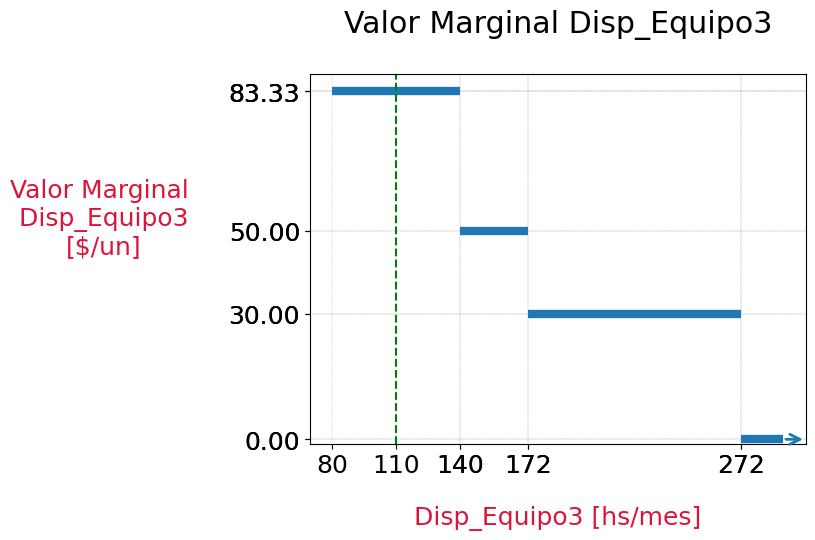

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# AHORA SÍ GRAFICO
plot_text = get_text_for_plot("[hs/mes]", "[$/un]")
plot(new_rhs, new_dual, real_rhs_value, plot_text)